In [2]:
label_mapping = {
    'Angle_C_Au_I': r'$\theta_{\mathrm{C-Au-I}}$',
    'Bond_Au_C': r'$d_{\mathrm{Au-C}}$',
    'Bond_Au_I': r'$d_{\mathrm{Au-I}}$',
    'Bond_C_I': r'$d_{\mathrm{C-I}}$',
    'Bond_Au_Au': r'$d_{\mathrm{Au-Au}}$',
    'Farthest_Distance': r'$d_{\mathrm{max}}$',
    'Mol_Size_Short': r'$L_{\mathrm{short}}$',
    'AtomNum': r'$N_{\mathrm{atoms}}$',
    'Volume': r'$V_{\mathrm{mol}}$',
    'Density': r'$\rho$',
    'SDP': r'$SDP$',

    'c_CM5_Au1': r'$q_{\mathrm{Au1}}^{\mathrm{CM5}}$',
    'c_CM5_Au2': r'$q_{\mathrm{Au2}}^{\mathrm{CM5}}$',
    'c_CM5_C': r'$q_{\mathrm{C}}^{\mathrm{CM5}}$',
    'c_CM5_I': r'$q_{\mathrm{I}}^{\mathrm{CM5}}$',
    'c_CM5_P1': r'$q_{\mathrm{P1}}^{\mathrm{CM5}}$',
    'c_CM5_P2': r'$q_{\mathrm{P2}}^{\mathrm{CM5}}$',
    
    'c_Mulli_Au2': r'$q_{\mathrm{Au2}}^{\mathrm{Mul(xTB)}}$',
    'c_Mulli_C': r'$q_{\mathrm{C}}^{\mathrm{Mul(xTB)}}$',
    'c_Mulli_I': r'$q_{\mathrm{I}}^{\mathrm{Mul(xTB)}}$',
    'c_Mulli_P1': r'$q_{\mathrm{P1}}^{\mathrm{Mul(xTB)}}$',
    'c_Mulli_P2': r'$q_{\mathrm{P2}}^{\mathrm{Mul(xTB)}}$',
    
    'Mulliken_pop_Au_2': r'$q_{\mathrm{Au2}}^{\mathrm{Mul}}$',
    'Mulliken_pop_C': r'$q_{\mathrm{C}}^{\mathrm{Mul}}$',
    'Mulliken_pop_I': r'$q_{\mathrm{I}}^{\mathrm{Mul}}$',
    'Mulliken_pop_P_1': r'$q_{\mathrm{P1}}^{\mathrm{Mul}}$',
    'Mulliken_pop_P_2': r'$q_{\mathrm{P2}}^{\mathrm{Mul}}$',
    
    'Hirshfeld_c_C': r'$q_{\mathrm{C}}^{\mathrm{Hir}}$',
    'Hirshfeld_c_P_1': r'$q_{\mathrm{P1}}^{\mathrm{Hir}}$',
    'Hirshfeld_c_P_2': r'$q_{\mathrm{P2}}^{\mathrm{Hir}}$',
    
    'EA': r'$EA$',
    'LEA_Ave': r'$\overline{LEA}$',


    'Hirshfeld_ob_l_C': r'$w_{\mathrm{LUMO, C}}^{\mathrm{Hir}}$',
    'Hirshfeld_ob_l_I': r'$w_{\mathrm{LUMO, I}}^{\mathrm{Hir}}$',
    'l_shell_d': r'$w_{d}^{\mathrm{LUMO}}$',
    'Pop_type_d_I': r'$n_{d}^{\mathrm{I}}$',
    'Pop_type_p_C': r'$n_{p}^{\mathrm{C}}$',
    'Pop_type_p_I': r'$n_{p}^{\mathrm{I}}$',
    'Pop_type_s_I': r'$n_{s}^{\mathrm{I}}$',

    'Atom_d_m_Z_Au_1': r'$\mu_{z}^{\mathrm{Au1}}$',
    'Atom_d_m_X_Au_1': r'$\mu_{x}^{\mathrm{Au1}}$',
    'Atom_d_m_Z_I': r'$\mu_{z}^{\mathrm{I}}$',
    'Atom_d_m_C': r'$\mu_{\mathrm{C}}$',
    'd_m_X': r'$\mu_{x}^{\mathrm{mol}}$',


    'bv_P_1': r'$V_{\mathrm{bur}}^{\mathrm{P1}}$',
    'bv_P_2': r'$V_{\mathrm{bur}}^{\mathrm{P2}}$',
    'sasa_P_1': r'$SASA_{\mathrm{P1}}$',
    'sasa_P_2': r'$SASA_{\mathrm{P2}}$',
    'disp_volume': r'$V_{\mathrm{disp}}$',
    'pyr_p_Au_1': r'$\tau_{\mathrm{pyr}}^{\mathrm{Au1}}$',
    'pyr_P_angle_Au_1': r'$\theta_{\mathrm{pyr}}^{\mathrm{Au1}}$'
}

In [ ]:
import sys, os
import time
import pandas as pd
import logging
from units.models import ModelTrainer
from units.unit import load_data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

start_time = time.time()

y_type = 'dG_kcal_mol'

local_descriptors = pd.read_csv('all_descriptor.csv',index_col='name')
local_descriptors = local_descriptors.drop(columns=['HOMO','HOMO_number', 'LUMO', 'HOMO_LUMO_Gap'])
combined_descriptors = pd.concat([local_descriptors], axis=1)

data = combined_descriptors
data_y = pd.read_csv('dG_ddG_PXP_cat_ts.csv', index_col=0)

data = data.loc[data_y.index]

y = data_y[y_type]

nan_columns = data.columns[data.isnull().any()].tolist()
constant_columns = data.columns[data.nunique() == 1].tolist()

columns_to_drop = list(set(nan_columns + constant_columns))
if columns_to_drop:
    print(f"⚠️ Warning: Found {len(columns_to_drop)} problematic feature columns that need to be removed.")
    if nan_columns:
        print(f"  - {len(nan_columns)} columns contain NaN values: {nan_columns}")
    if constant_columns:
        print(f"  - {len(constant_columns)} columns are constant: {constant_columns}")
    
    data = data.drop(columns=columns_to_drop)

cols = data.columns

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(data), 
                index=y.index, 
                columns=cols)
corr = X.corr().abs()
keep = []
for i in range(len(corr.columns)):
    above = corr.iloc[:i,i]
    if keep: above = above[keep]
    if all(above < 0.95):
        keep.append(corr.columns[i])
X = X[keep]
if y_type == 'ddG_kcal_mol':
    X = X[
            [
        'c_CM5_Au2',
        'Farthest_Distance',
        'Mol_Size_Short',
        'Bond_Au_C',
        'Angle_C_Au_I',
        'bv_P_1',
        'bv_P_2',
        'pyr_p_Au_1',
        'sasa_P_1',
        'sasa_P_2'
            ]
        ]
elif y_type == 'dG_kcal_mol':
    X = X[
            [
        'c_Mulli_P1',
        'LEA_Ave',
        'Bond_Au_I',
        'Angle_C_Au_I',
        'sasa_P_2',
        'l_shell_d',
        'Pop_type_s_I',
        'Pop_type_p_I',
        'Atom_d_m_Z_Au_1',
        'd_m_X'
            ]
        ]

print(f"Data shape after removing highly correlated features: {X.shape}")

⚠️ Warning: Found 11 problematic feature columns that need to be removed.
  - 2 columns contain NaN values: ['Mayer_Bo', 'Atom_connec']
  - 9 columns are constant: ['IP_shift', 'EA_shift', 'h_shell_f', 'l_shell_f', 'Pop_type_f_Au_1', 'Pop_type_f_Au_2', 'Pop_type_d_C', 'Pop_type_f_C', 'Pop_type_f_I']
Data shape after removing highly correlated features: (138, 10)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score


ridge_model = RidgeCV(cv=5)


ridge_model.fit(X_train, y_train)

train_pred = ridge_model.predict(X_train)
test_pred = ridge_model.predict(X_test)

metrics = {
    'Train R2': r2_score(y_train, train_pred),
    'Train MAE': mean_absolute_error(y_train, train_pred),
    'Test R2': r2_score(y_test, test_pred),
    'Test MAE': mean_absolute_error(y_test, test_pred)
}

metrics

{'Train R2': 0.8945802430471408,
 'Train MAE': 1.9468369961076275,
 'Test R2': 0.8518504192001349,
 'Test MAE': 2.3935194768296326}

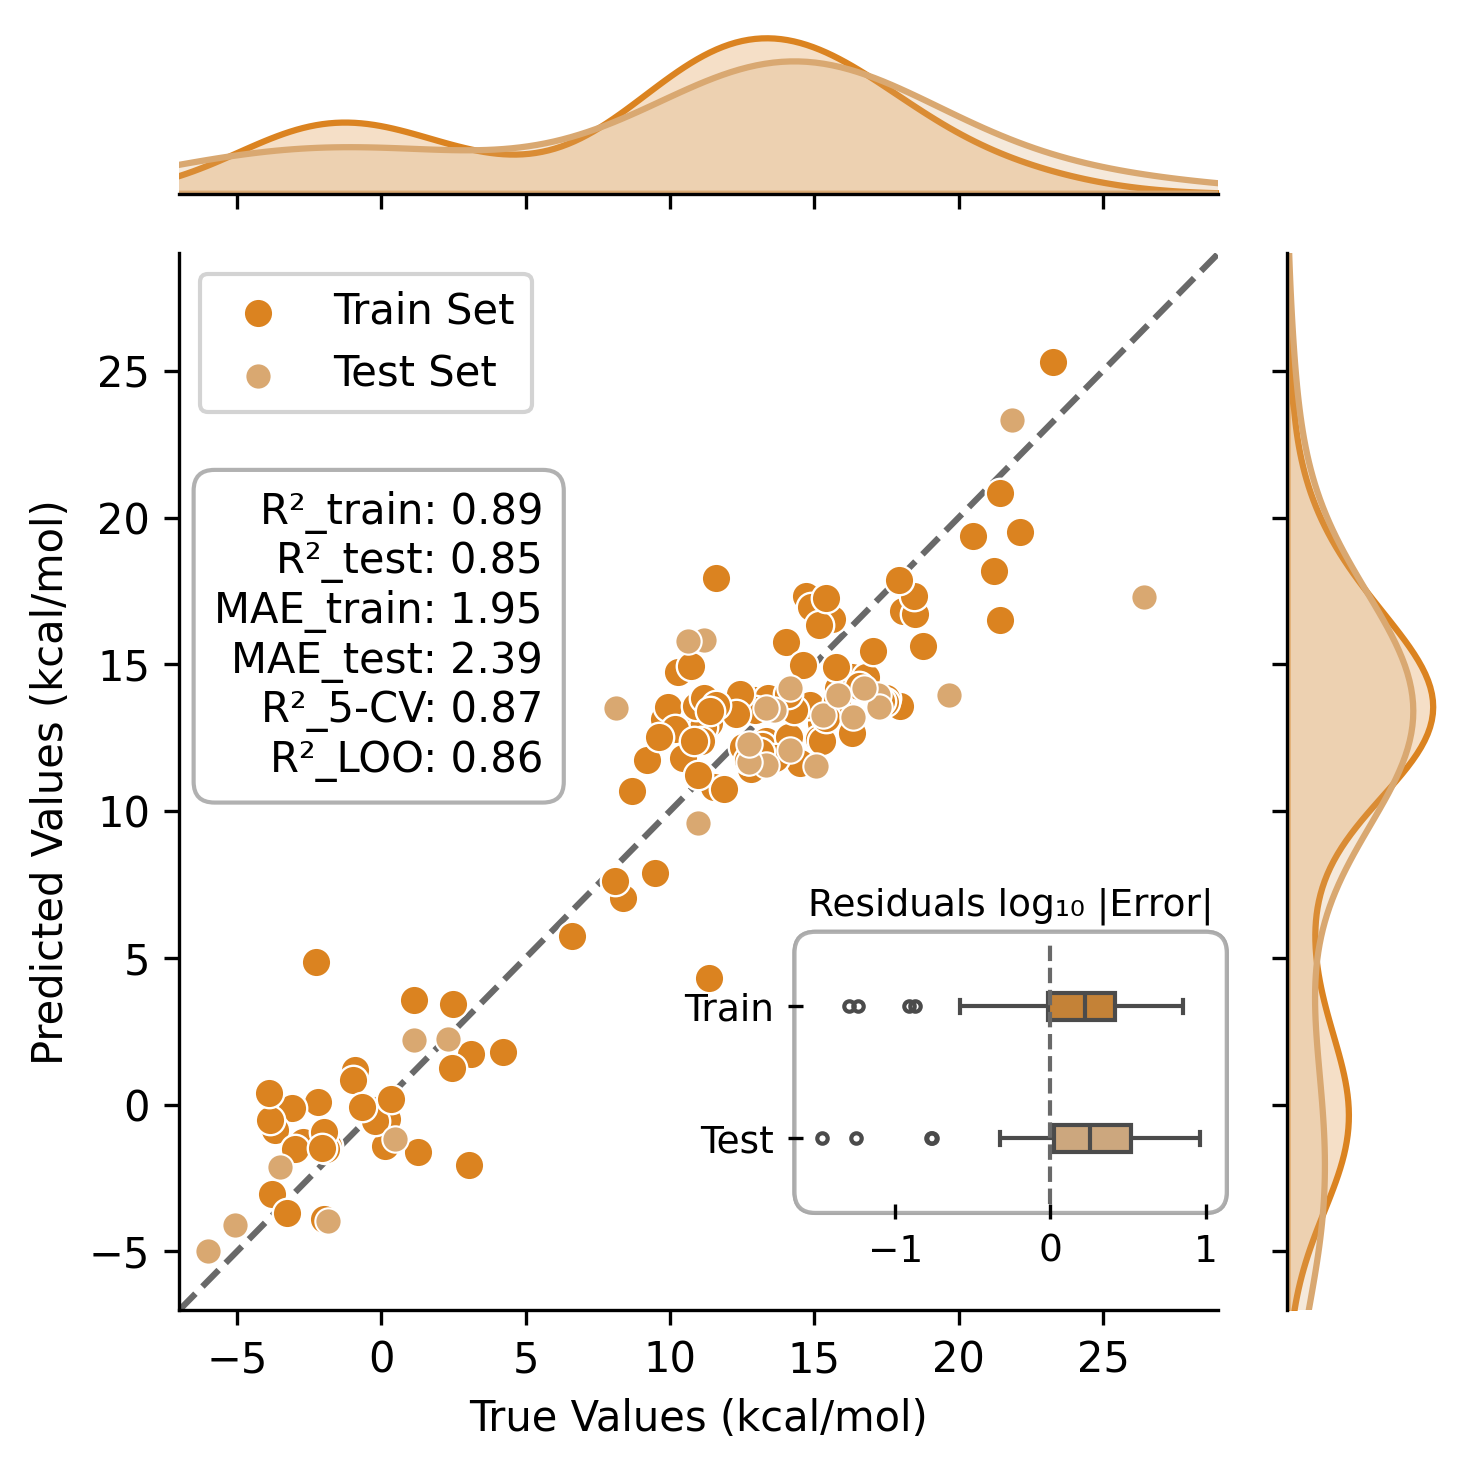

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl


g = sns.JointGrid(height=5, ratio=5, space=0.1)
g.fig.set_dpi(300)
g.fig.patch.set_facecolor('white')
sns.scatterplot(x=y_train, y=train_pred, ax=g.ax_joint, color='#db8320', label='Train Set', s=50, zorder=3)
sns.scatterplot(x=y_test, y=test_pred, ax=g.ax_joint, color="#d9a871", label='Test Set', s=40, zorder=3)
sns.kdeplot(x=y_train, ax=g.ax_marg_x, color='#db8320', fill=True, linewidth=1.5)
sns.kdeplot(x=y_test, ax=g.ax_marg_x, color='#d9a871', fill=True, linewidth=1.5)
sns.kdeplot(y=train_pred, ax=g.ax_marg_y, color='#db8320', fill=True, linewidth=1.5)
sns.kdeplot(y=test_pred, ax=g.ax_marg_y, color='#d9a871', fill=True, linewidth=1.5)
axis_limits = [-7, 29]
g.ax_joint.set_xlim(axis_limits)
g.ax_joint.set_ylim(axis_limits)
g.ax_joint.plot(axis_limits, axis_limits, '--', linewidth=1.5, c='dimgray', label='', zorder=1)
g.set_axis_labels('True Values (kcal/mol)', 'Predicted Values (kcal/mol)', fontsize=10)
handles, labels = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(handles=handles, prop={'size': 10}, loc='upper left', frameon=True, facecolor='white', framealpha=0.85)
metrics_text = (f"R²_train: {metrics['Train R2']:.2f}\n"
                f"R²_test: {metrics['Test R2']:.2f}\n"
                f"MAE_train: {metrics['Train MAE']:.2f}\n"
                f"MAE_test: {metrics['Test MAE']:.2f}\n"
                f"R²_5-CV: {0.8660:.2f}\n"
                f"R²_LOO: {0.8639:.2f}")
g.ax_joint.text(0.35, 0.5, metrics_text, transform=g.ax_joint.transAxes, fontsize=10,
                verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.9, ec='darkgray'))

epsilon = 1e-9
train_log_abs_error = np.log10(np.abs(train_pred - y_train) + epsilon)
test_log_abs_error = np.log10(np.abs(test_pred - y_test) + epsilon)
log_error_df = pd.concat([
    pd.DataFrame({'LogAbsError': train_log_abs_error, 'Set': 'Train'}),
    pd.DataFrame({'LogAbsError': test_log_abs_error, 'Set': 'Test'})
])

inset_bbox = [0.6, 0.1, 0.4, 0.25]
ax_inset = g.ax_joint.inset_axes(inset_bbox)
sns.boxplot(y="Set", x="LogAbsError", data=log_error_df, ax=ax_inset,
            palette={'Train': '#db8320', 'Test': '#d9a871'},
            fliersize=2.5, linewidth=1, width=0.2)
ax_inset.set_title('Residuals log₁₀ |Error|', fontsize=9)
ax_inset.set_ylabel('') 
ax_inset.set_xlabel('') 
ax_inset.axvline(0, color='dimgray', linestyle='--', linewidth=1)
ax_inset.tick_params(axis='x', labelsize=9)
ax_inset.tick_params(axis='y', labelsize=9)

ax_inset.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

new_patch = mpl.patches.FancyBboxPatch(
    xy=(0, 0),
    width=1,
    height=1,
    facecolor="white",
    edgecolor="darkgray",
    alpha=0.9,
    boxstyle="round,pad=0.02,rounding_size=0.05",
    transform=ax_inset.transAxes, 
    clip_on=False,
    linewidth=1,
    mutation_aspect=inset_bbox[2] / inset_bbox[3]
)

ax_inset.add_patch(new_patch)
ax_inset.patch = new_patch

plt.tight_layout()
plt.show()

Starting SHAP KernelExplainer...


Using 138 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Defining masks for 'di_pn' and 'Others'...
Calculating SHAP values for 'di_pn'...


100%|██████████| 40/40 [00:00<00:00, 62.99it/s]


Calculating SHAP values for 'Others'...


100%|██████████| 98/98 [00:01<00:00, 73.50it/s]



Generating the stacked bar chart for the top 15 features...


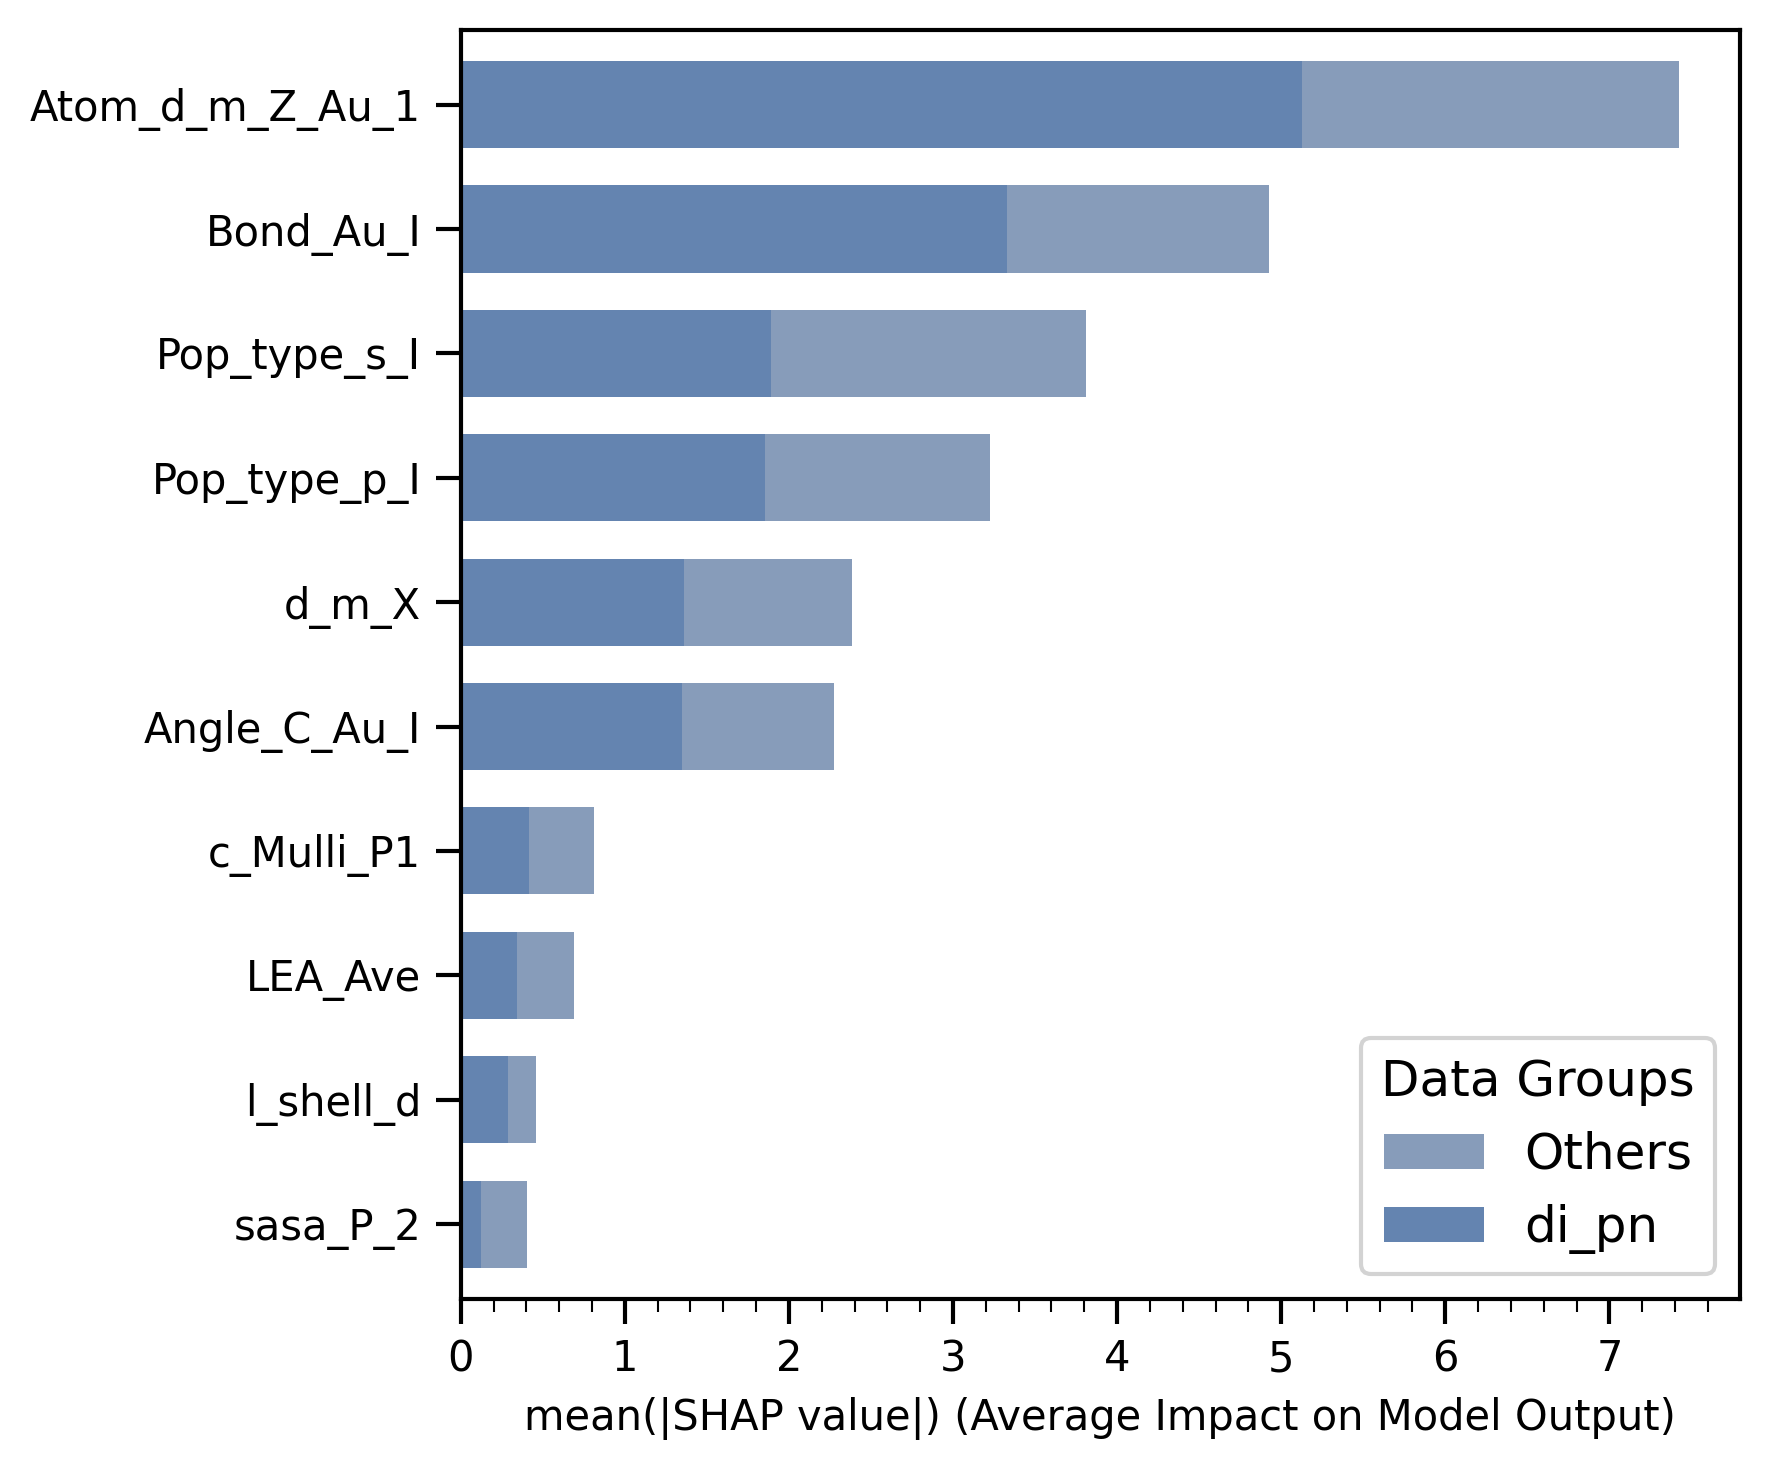

In [8]:
import shap

print("Starting SHAP KernelExplainer...")
X_train_summary = shap.kmeans(X, len(X)) 

explainer = shap.KernelExplainer(ridge_model.predict, X_train_summary)
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


N_FEATURES_TO_SHOW = 15

group_of_interest = 'di_pn'
other_group_label = 'Others'

print(f"Defining masks for '{group_of_interest}' and '{other_group_label}'...")

mask_interest = X.index.str.startswith('di_pn')
mask_others = ~mask_interest

X_interest = X[mask_interest]
X_others = X[mask_others]


shap_results = {}

if not X_interest.empty:
    print(f"Calculating SHAP values for '{group_of_interest}'...")
    shap_values_interest = explainer.shap_values(X_interest, check_additivity=False)
    mean_abs_shap_interest = np.mean(np.abs(shap_values_interest), axis=0)
    shap_results[group_of_interest] = mean_abs_shap_interest
else:
    print(f"Warning: No samples found for group '{group_of_interest}'.")

if not X_others.empty:
    print(f"Calculating SHAP values for '{other_group_label}'...")
    shap_values_others = explainer.shap_values(X_others, check_additivity=False)
    mean_abs_shap_others = np.mean(np.abs(shap_values_others), axis=0)
    shap_results[other_group_label] = mean_abs_shap_others
else:
    print(f"Warning: No samples found for group '{other_group_label}'.")

shap_df = pd.DataFrame(shap_results, index=X.columns)

shap_df['total_importance'] = shap_df.sum(axis=1)

top_shap_df = shap_df.nlargest(N_FEATURES_TO_SHOW, 'total_importance')

sorted_top_shap_df = top_shap_df.sort_values(by='total_importance', ascending=True)

sorted_top_shap_df = sorted_top_shap_df.drop(columns='total_importance')

print(f"\nGenerating the stacked bar chart for the top {N_FEATURES_TO_SHOW} features...")
fig, ax = plt.subplots(figsize=(6, 5), dpi=300)

colors = ['#6484b0', '#879cba']

ax = sorted_top_shap_df.plot(
    kind='barh',
    stacked=True,
    color=colors,
    ax=ax,
    zorder=3,
    width=0.7
)


fig.patch.set_facecolor('white')

plt.xlabel("mean(|SHAP value|) (Average Impact on Model Output)", fontsize=10)
plt.ylabel("")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', which='major', direction='out', 
               length=6, width=1, colors='black')
ax.tick_params(axis='both', which='minor', direction='out', 
               length=3, width=0.5, colors='black')

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.0)
ax.spines['left'].set_zorder(5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles[::-1],
    labels=labels[::-1],
    title="Data Groups",
    loc='lower right',
    fontsize=12,
    frameon=True,
    facecolor='white',
    framealpha=0.85,
    title_fontsize=12
)

plt.tight_layout()
plt.show()



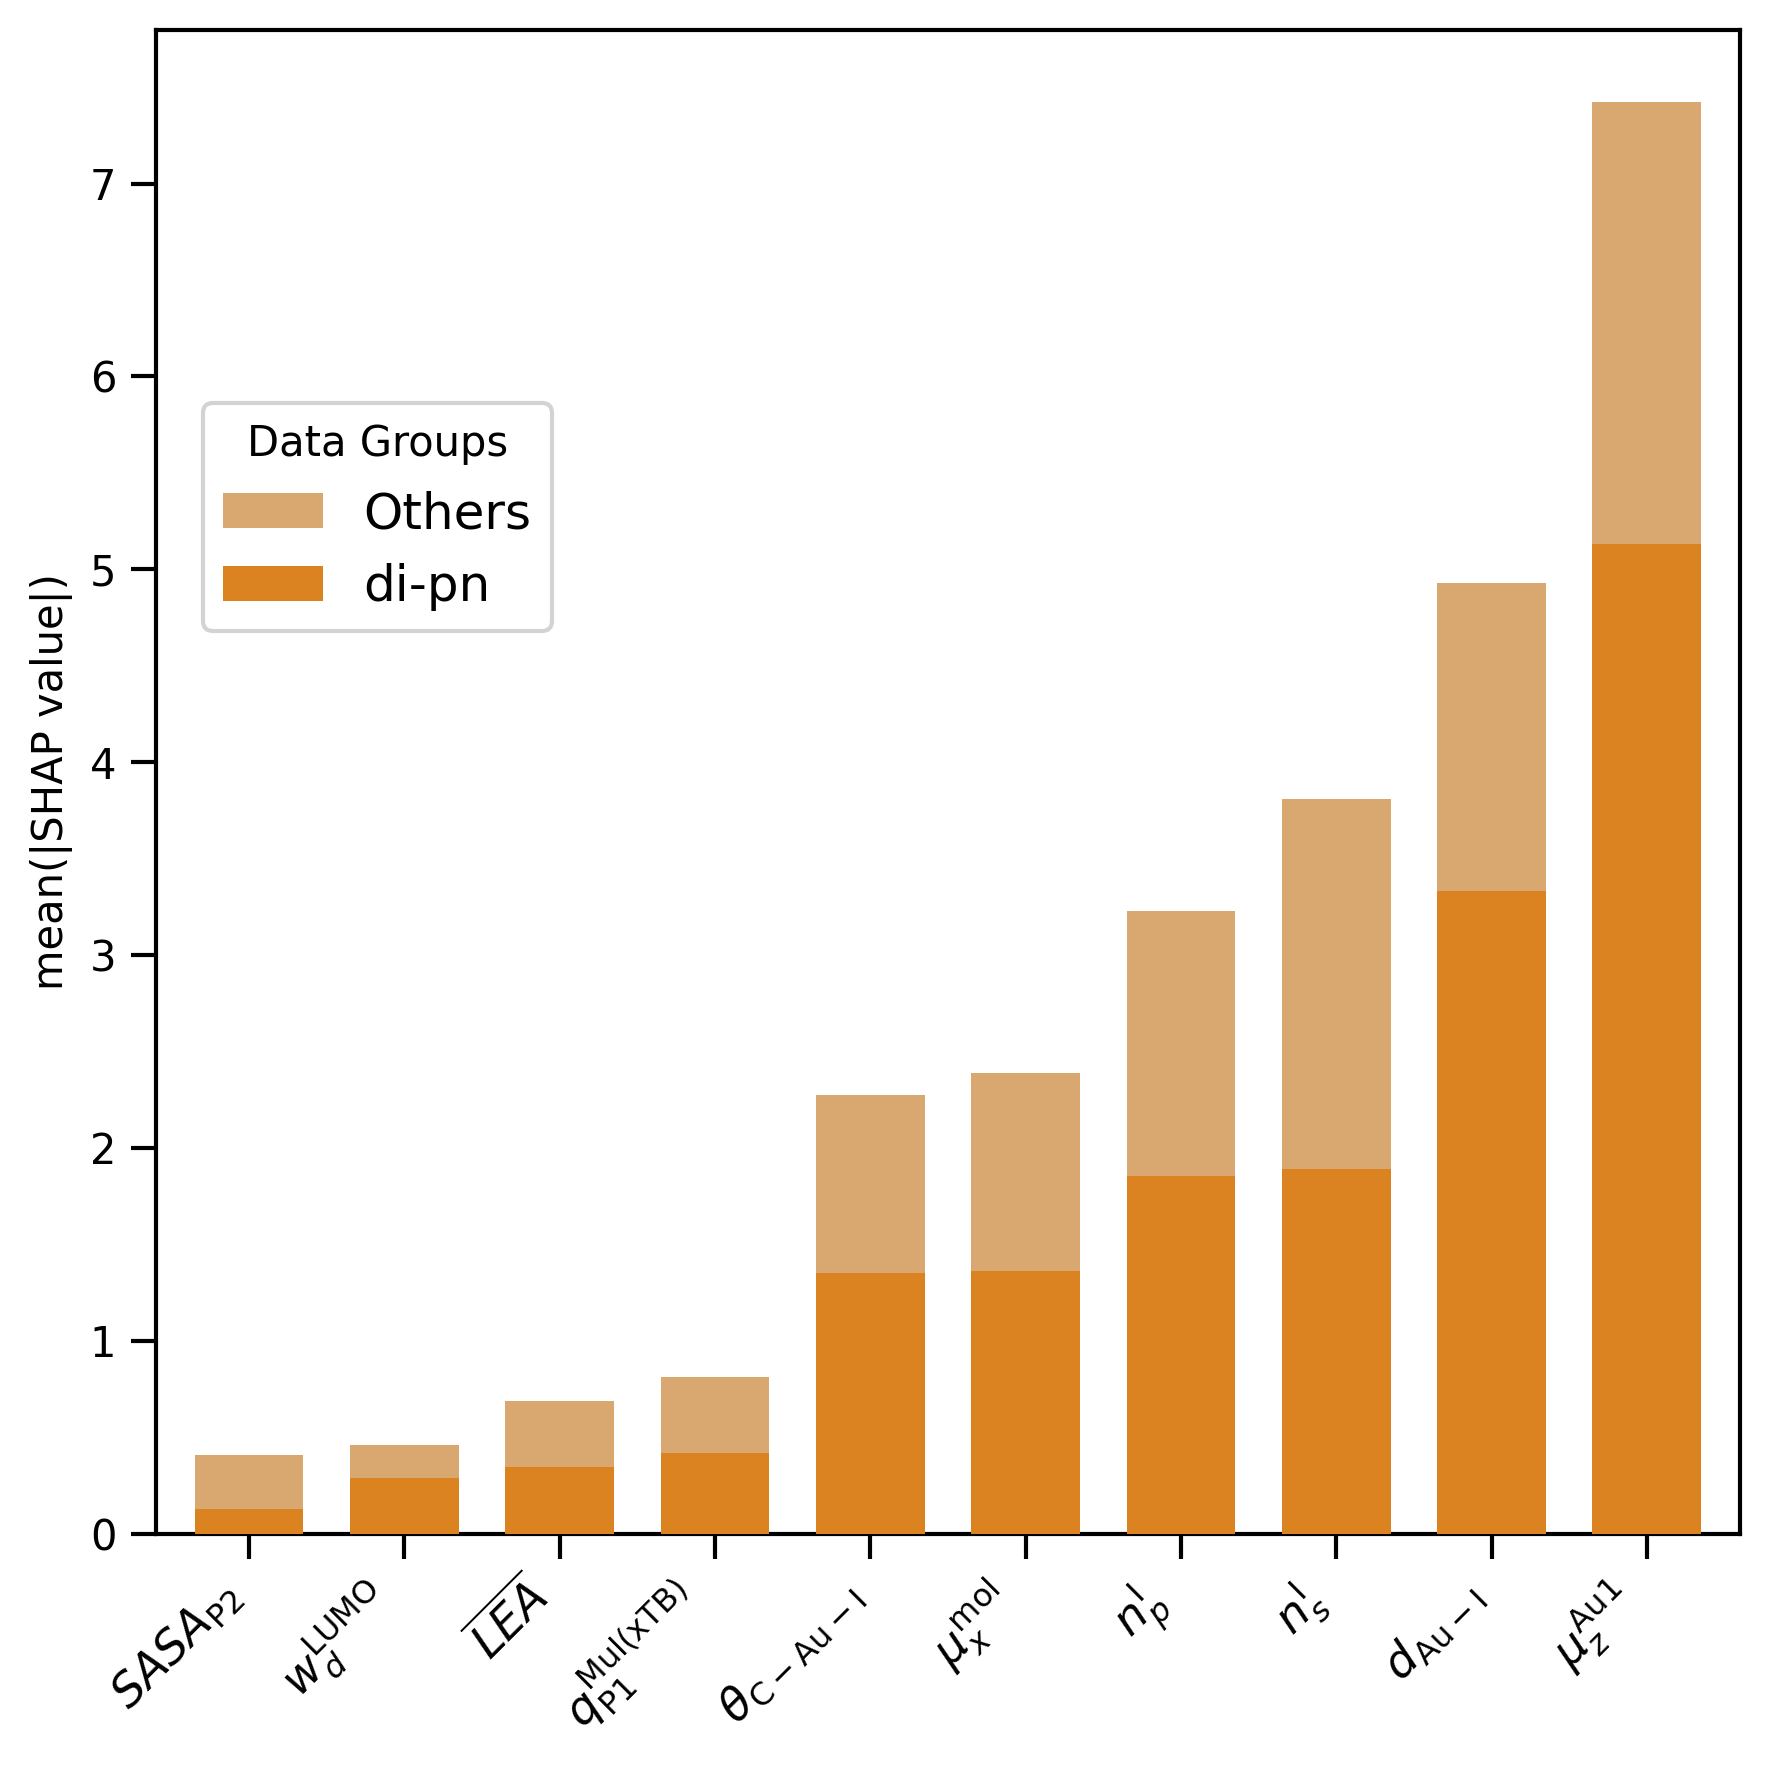

In [9]:
def get_display_name(name):
    return label_mapping.get(name, name.replace('_', r'\_'))

fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
colors = ['#db8320', '#d9a871']

ax = sorted_top_shap_df.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=ax,
    zorder=3,
    width=0.7
)
fig.patch.set_facecolor('white')
current_labels = [tick.get_text() for tick in ax.get_xticklabels()]
new_labels = [get_display_name(l) for l in current_labels]


ax.set_xticklabels(new_labels, rotation=45, ha='right', fontsize=11)

plt.ylabel("mean(|SHAP value|)", fontsize=10)
plt.xlabel("")

ax.tick_params(axis='both', which='major', direction='out', 
               length=6, width=1, colors='black')
ax.tick_params(axis='both', which='minor', direction='out', 
               length=3, width=0.5, colors='black')
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.0)
ax.spines['left'].set_zorder(5)
handles, labels = ax.get_legend_handles_labels()
labels = [label.replace("di_pn", "di-pn") for label in labels]
ax.legend(
    handles=handles[::-1],
    labels=labels[::-1],
    title="Data Groups",
    loc=(0.03, 0.6),
    fontsize=12,
    frameon=True,
    facecolor='white',
    framealpha=0.85,
    title_fontsize=10
)
plt.tight_layout()
plt.show()

In [11]:
from sklearn.model_selection import (
    LeaveOneOut,
    cross_val_score,
    train_test_split,
    cross_val_predict,
)
cv_r2 = float(
        cross_val_score(
            ridge_model,
            X_train,
            y_train,
            cv=5,
            scoring="r2",
        ).mean()
)
loo_model = cross_val_predict(
    ridge_model,
    X,
    y,
    cv=LeaveOneOut(),
)
loo_r2 = float(r2_score(y, loo_model))
loo_mae = float(mean_absolute_error(y, loo_model))

print(f"CV R2: {cv_r2:.4f}")
print(f"LOO R2: {loo_r2:.4f}")
print(f"LOO MAE: {loo_mae:.4f}")

CV R2: 0.8660
LOO R2: 0.8639
LOO MAE: 2.1725


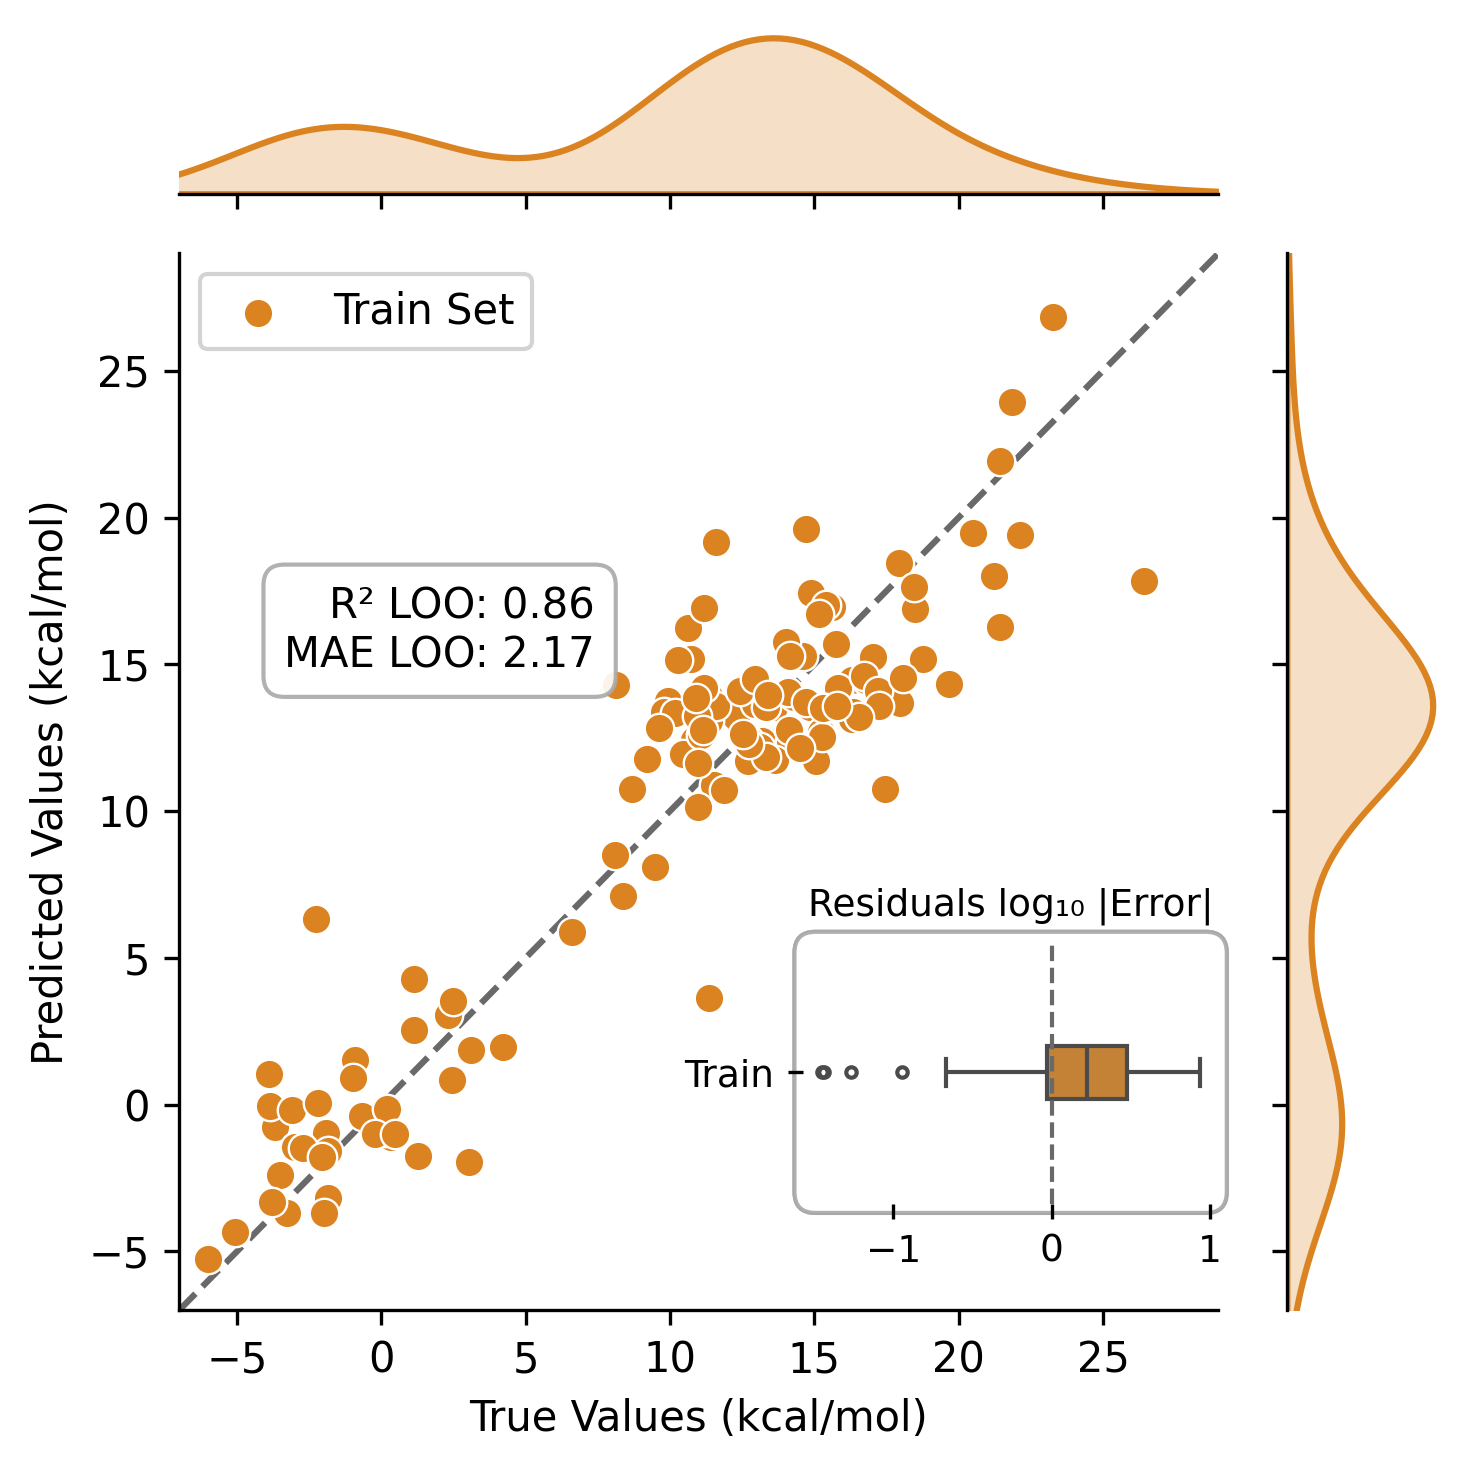

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl


g = sns.JointGrid(height=5, ratio=5, space=0.1)
g.fig.set_dpi(300)
g.fig.patch.set_facecolor('white')
sns.scatterplot(x=y, y=loo_model, ax=g.ax_joint, color='#db8320', label='Train Set', s=50, zorder=3)

sns.kdeplot(x=y, ax=g.ax_marg_x, color='#db8320', fill=True, linewidth=1.5)

sns.kdeplot(y=loo_model, ax=g.ax_marg_y, color='#db8320', fill=True, linewidth=1.5)

axis_limits = [-7, 29]
g.ax_joint.set_xlim(axis_limits)
g.ax_joint.set_ylim(axis_limits)
g.ax_joint.plot(axis_limits, axis_limits, '--', linewidth=1.5, c='dimgray', label='', zorder=1)
g.set_axis_labels('True Values (kcal/mol)', 'Predicted Values (kcal/mol)', fontsize=10)
handles, labels = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(handles=handles, prop={'size': 10}, loc='best', frameon=True, facecolor='white', framealpha=0.85)

metrics_text = (f"R² LOO: {loo_r2:.2f}\n"
                f"MAE LOO: {loo_mae:.2f}")
g.ax_joint.text(0.4, 0.6, metrics_text, transform=g.ax_joint.transAxes, fontsize=10,
                verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.9, ec='darkgray'))

epsilon = 1e-9
train_log_abs_error = np.log10(np.abs(loo_model - y) + epsilon)

log_error_df = pd.concat([
    pd.DataFrame({'LogAbsError': train_log_abs_error, 'Set': 'Train'}),

])

inset_bbox = [0.6, 0.1, 0.4, 0.25]
ax_inset = g.ax_joint.inset_axes(inset_bbox)
sns.boxplot(y="Set", x="LogAbsError", data=log_error_df, ax=ax_inset,
            palette={'Train': '#db8320', 'Test': '#708090'},
            fliersize=2.5, linewidth=1, width=0.2)
ax_inset.set_title('Residuals log₁₀ |Error|', fontsize=9)
ax_inset.set_ylabel('')
ax_inset.set_xlabel('')
ax_inset.axvline(0, color='dimgray', linestyle='--', linewidth=1)
ax_inset.tick_params(axis='x', labelsize=9)
ax_inset.tick_params(axis='y', labelsize=9)

ax_inset.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

new_patch = mpl.patches.FancyBboxPatch(
    xy=(0, 0),
    width=1,
    height=1,
    facecolor="white",
    edgecolor="darkgray",
    alpha=0.9,
    boxstyle="round,pad=0.02,rounding_size=0.05",
    transform=ax_inset.transAxes,
    clip_on=False,
    linewidth=1,

    mutation_aspect=inset_bbox[2] / inset_bbox[3]
)

ax_inset.add_patch(new_patch)
ax_inset.patch = new_patch

plt.tight_layout()
plt.show()

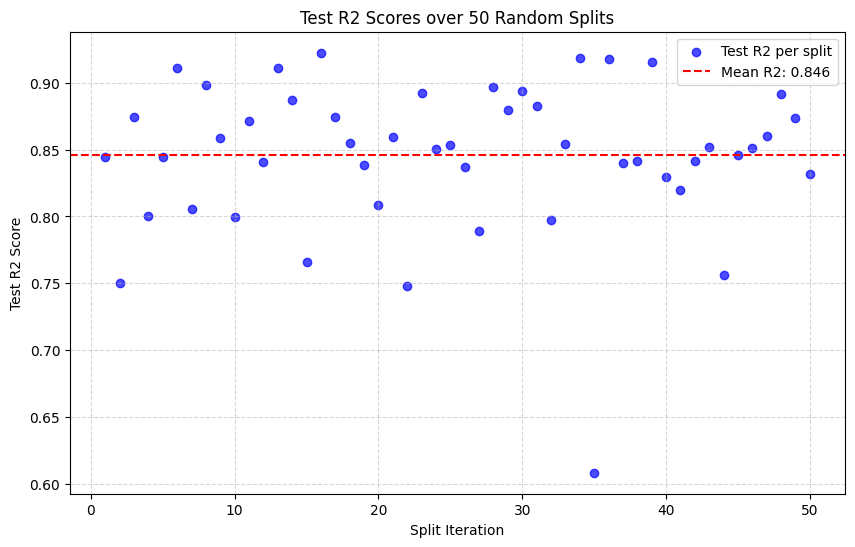

50 split Test ave R2 scores: 0.8459


In [13]:
test_r2_scores = []
num_splits = 50


import matplotlib.pyplot as plt

for i in range(num_splits):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)


    ridge_model = RidgeCV(cv=5)

    ridge_model.fit(X_train, y_train)

    test_pred = ridge_model.predict(X_test)
    r2 = r2_score(y_test, test_pred)
    test_r2_scores.append(r2)


plt.figure(figsize=(10, 6))

x_axis = range(1, num_splits + 1)
plt.scatter(x_axis, test_r2_scores, color='blue', alpha=0.7, label='Test R2 per split')

mean_r2 = np.mean(test_r2_scores)
plt.axhline(y=mean_r2, color='red', linestyle='--', label=f'Mean R2: {mean_r2:.3f}')

plt.title('Test R2 Scores over 50 Random Splits')
plt.xlabel('Split Iteration')
plt.ylabel('Test R2 Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

print(f"50 split Test ave R2 scores: {mean_r2:.4f}")

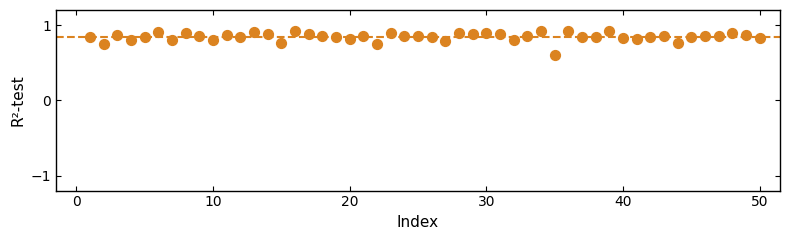

In [14]:
plt.figure(figsize=(8, 2.5))

plt.scatter(range(1, 51), test_r2_scores, color='#db8320', s=50, marker='o')

plt.xlabel('Index', fontsize=11)
plt.ylabel('R²-test', fontsize=11)

plt.xticks(np.arange(0, 51, 10), fontsize=10)
plt.yticks([-1, 0, 1], fontsize=10)

plt.xlim(-1.5, 51.5)
plt.ylim(-1.2, 1.2)

ax = plt.gca()

ax.tick_params(direction='in', top=True, right=True, which='both')


mean_r2 = np.mean(test_r2_scores)
plt.axhline(y=mean_r2, color='#db8320', linestyle='--', label=f'Mean R2: {mean_r2:.3f}')

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

plt.tight_layout()

plt.show()